In [30]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Basic Setup

Create anaconda environment
<br>
```bash
conda create -n ml python=3.7.5 jupyter
```
Install fastai library
<br>
```bash
conda install -c pytorch -c fastai fastai
```

In [2]:
import matplotlib.pyplot as plt

## Prepare the dataset

In [31]:
import numpy as np

In [3]:
from sklearn.datasets import fetch_openml

In [4]:
X, y_str = fetch_openml('mnist_784', version=1, return_X_y=True)

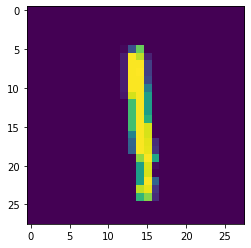

In [10]:
img1 = X[8].reshape(28, 28)
plt.imshow(img1)

In [14]:
y_str[8]

'1'

In [15]:
y_int = y_str.astype(int)

def encode_idx(idx):
    cd = np.zeros(10)
    cd[idx] = 1
    
    return cd
    
y_v = np.array([encode_idx(i) for i in y_int])

In [17]:
y_v.shape

(70000, 10)

In [18]:
y_v[8]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
X_norm = X / 255.

In [20]:
X_train, X_test = X_norm[:60000], X[60000:]
y_train, y_test = y_v[:60000], y_v[60000:]

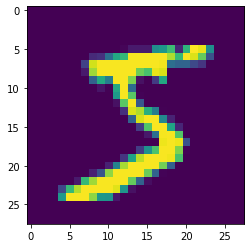

In [21]:
img_norm = X_train[0].reshape(28, 28)
plt.imshow(img_norm)

In [22]:
training_dt = [(x.reshape(784, 1), y.reshape(10, 1)) for (x, y) in zip(X_train, y_train)]
test_dt = [(x.reshape(784, 1), y.reshape(10, 1)) for (x, y) in zip(X_test, y_test)]

In [27]:
test_dt[0][1]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.]])

## Create the Model

In [28]:
import random

Define sigmoid function

In [32]:
def sigmoid(z:np.ndarray):
    return 1.0 / (1.0 + np.exp(-z))

Define derivative of sigmoid function

In [33]:
def sigmoid_der(z):
    return sigmoid(z) * (1 - sigmoid(z))

Implement the linear layer of our neural network
<br>
$$
z = Wx + b
$$

In [35]:
class Linear(object):
    
    def __init__(self, din:int, dout:int, bias:bool=True):
        super().__init__()
        self.din = din
        self.dout = dout
        self.bias = bias
        self.W = np.random.randn(dout, din)
        self.b = np.random.randn(dout, 1)
        self.a = None
        self.z = None
        self.der_W = np.zeros(self.W.shape)
        self.der_b = np.zeros(self.b.shape)
        
    def forward(self, a:np.ndarray):
        self.a = a
        self.z = self.W @ a + self.b
        
        return self.z
    
    def backward(self, delta_n:np.ndarray, z_p:np.ndarray):
        sd = sigmoid_der(z_p)
        delta = (self.W.T @ delta_n) * sd
        self.der_W += delta_n @ self.a.T
        self.der_b += delta_n
        
        return delta
    
    def zero_grad(self):
        self.der_W = np.zeros(self.W.shape)
        self.der_b = np.zeros(self.b.shape)
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
    def __str__(self):
        return f'Linear({self.din}, {self.dout})'
    
    def __repr__(self):
        return self.__str__()

Here din is dimension of previous leyer and dout is the dimension of this layer
<br>
Store in der_W gradient of the cost function with this layer's weights and in der_b gradient with biases

Also store previous layer's activation and current z in forward pass in order to calculate gradients with deltas

In 
```python
def backward(self, delta_n:np.ndarray, z_p:np.ndarray):
    sd = sigmoid_der(z_p)
    delta = (self.W.T @ delta_n) * sd
    self.der_W += delta_n @ self.a.T
    self.der_b += delta_n

    return delta
``` 
we pass next layers $\delta$ as delta_n and previous layers $z$ as z_p
<br>
Then calculate $\sigma'(z^l_j)$ with 
```python 
sigmoid_der(z_p) 
```
and $\delta = ((w)^T \delta) \odot \sigma'(z)$ for previous layer and we'll pass in to the previous layers backward function.
<br>
$$\delta^l = ((w^{l+1})^T \delta^{l+1}) \odot \sigma'(z^l)$$
here 
- $w^{l+1}$ = self.W 
- $\delta^{l+1}$ = delta_n
- $z^l$ is z_p
We also accumulate sum of the calculated gradients in der_W (for weights) and der_b (for biases) in order to use it in mean calculation in batch for gradient descent

```python
def zero_grad(self):
    self.der_W = np.zeros(self.W.shape)
    self.der_b = np.zeros(self.b.shape)
```
Cleans accumulated gradients for next batch processing

Let's run feed forward our linear layer

In [38]:
x = np.random.rand(28*28, 1)
layer = Linear(28*28, 28*28 + 100)
z = layer(x)
a = sigmoid(z)
a.shape

(884, 1)

Now we can implement the network

In [40]:
class NNetwork(object):
    
    def __init__(self):
        super().__init__()
        self.layers = list()
        
    def forward(self, *args, **kwargs):
        pass
    
    def backward(self, x, y, out, **kwargs):
        z_p = None,
        delta = (out - y) * sigmoid_der(self.layers[-1].z)
        for i in range(1, len(self.layers) + 1):
            layer = self.layers[-i]
            z_p = self.layers[-i - 1].z if i < len(self.layers) else x
            delta = layer.backward(delta, z_p)
            
    def zero_grad(self):
        for layer in self.layers:
            layer.zero_grad()
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
    def __setattr__(self, name, value):
        super().__setattr__(name, value)
        if not hasattr(self, 'layers'):
            self.layers = []
        if isinstance(value, Linear):
            self.layers.append(value)

Here
```python
def __setattr__
```
will store all linear layers in list for further automatic processing
the method:
```python
def backward(self, x, y, out, **kwargs):
    z_p = None,
    delta = (out - y) * sigmoid_der(self.layers[-1].z)
    for i in range(1, len(self.layers) + 1):
        layer = self.layers[-i]
        z_p = self.layers[-i - 1].z if i < len(self.layers) else x
        delta = layer.backward(delta, z_p)
```
First in will calculate delta for cost function:
$$
\frac{1}{2n} \sum_x \| y(x) - a\|^2.
$$
<br>
$$
\delta^L = \nabla_a C \odot \sigma'(z^L).
$$
by
```python
delta = (out - y) * sigmoid_der(self.layers[-1].z)
```
Then layer by layer from end to beginning runs backpropagation calls each layers backward function passing the next layers delta_n ($\delta^{l+1}$) and previous layers z_p ($z^{l-1}$) and calculates deltas on the fly, layers accumulate gradients sum for weights and biases as we implemented above
<br>
The method
```python
def zero_grad
```
Cleans gradients by weighs and biases for each layer for next batch processing

#### Simple feed forward model

In [77]:
class NNModel(NNetwork):
    
    def __init__(self):
        super().__init__()
        #put layers here like
        self.fc1 = Linear(784, 100)
        self.fc2 = Linear(100, 100)
        self.fc3 = Linear(100, 10)
    
        
    def forward(self, x:np.ndarray):
        # make the forward call
        z1 = self.fc1(x)
        a1 = sigmoid(z1)
        z2 = self.fc2(a1)
        a2 = sigmoid(z2)
        z3 = self.fc3(a2)
        out = sigmoid(z3)
        
        return out
        

In [80]:
model = NNModel()

In [81]:
model.layers

[Linear(784, 100), Linear(100, 100), Linear(100, 10)]

In [82]:
x.shape

(784, 1)

Let's run our model on randomly generated data

In [83]:
pred = model(x)
#pred
out = np.argmax(pred)
out

8

Initialize random label and test backward (backpropagation) and zero_grad methods

In [84]:
y = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0]).reshape(10, 1)
y.shape

(10, 1)

In [85]:
model.backward(x, y, pred)

In [61]:
for ll in model.layers:
    print(ll.der_W.shape, ll.der_b.shape)

(15, 784) (15, 1)
(10, 15) (10, 1)


In [62]:
model.zero_grad()
for ll in model.layers:
    print(np.count_nonzero(ll.der_W), np.count_nonzero(ll.der_b))

0 0
0 0


Now we need to implement the loss function and gradient descent algorithm

In [64]:
class SGD(object):
    
    def __init__(self, lr):
        self.lr = lr
        
    def optimize(self, model, batch):
        for x, y in batch:
            y_hat = model(x)
            model.backward(x, y, y_hat)
        for layer in model.layers:
            layer.W = layer.W - self.lr * (layer.der_W / len(batch))
        model.zero_grad()

The stochastic gradient descent will calculate mean of gradients in batch then makes step for gradient descent with learning rate and cleans accumulated gradient s for next batch

In [87]:
optimizer = SGD(0.5)

After each epoch we'll run validation

In [66]:
def validate(model, test_data):
    y_hats = [(np.argmax(model(x)), np.argmax(y)) for (x, y) in test_data]
    valid_res = sum(int(x == y) for (x, y) in y_hats)
    
    return valid_res


Here we call model (with updated weights and biases) and compare it's output with labels and count correct predictions 

In [67]:
def train(model, optimizer, training_data, test_data, epochs:int=12, batch_size:int=16):
        n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            batches = [training_data[k:k + batch_size] for k in range(0, n, batch_size)]
            for batch in batches:
                 optimizer.optimize(model, batch)       
            if test_data:
                valid_res = validate(model, test_data)
                print(f'Epoch {j + 1}: {valid_res} / {n_test}, accuracy = {valid_res / n_test}')
            else:
                print(f'Epoch {j + 1} complete')

The training methods will iterate over the epochs, shuffle before each epoch data, group them in batches, run gradient descent per batch and validate model

Let's train the model

In [88]:
train(model, optimizer, training_dt, test_dt, 
      epochs=16, batch_size=32)

/Users/levan/anaconda3/envs/edu/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Epoch 0: 4748 / 10000, accuracy = 0.4748
Epoch 1: 5781 / 10000, accuracy = 0.5781
Epoch 2: 6027 / 10000, accuracy = 0.6027
Epoch 3: 6688 / 10000, accuracy = 0.6688
Epoch 4: 7815 / 10000, accuracy = 0.7815
Epoch 5: 7976 / 10000, accuracy = 0.7976
Epoch 6: 8071 / 10000, accuracy = 0.8071
Epoch 7: 8125 / 10000, accuracy = 0.8125
Epoch 8: 8160 / 10000, accuracy = 0.816
Epoch 9: 8174 / 10000, accuracy = 0.8174
Epoch 10: 8202 / 10000, accuracy = 0.8202
Epoch 11: 8237 / 10000, accuracy = 0.8237
Epoch 12: 8230 / 10000, accuracy = 0.823
Epoch 13: 8246 / 10000, accuracy = 0.8246
Epoch 14: 8276 / 10000, accuracy = 0.8276
Epoch 15: 8295 / 10000, accuracy = 0.8295
